<a href="https://colab.research.google.com/github/ramyanna12/Copy_of_Untitled3.ipynb/blob/main/PROJECTDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the dataset on Google Drive
dataset_path = '/content/drive/MyDrive/archive/'



In [ ]:
# Import necessary libraries
import numpy as np
import os
import struct



In [ ]:
# Define a function to load Fashion-MNIST dataset
def load_fashion_mnist(path):
    train_images_path = os.path.join(path, 'train-images-idx3-ubyte')
    train_labels_path = os.path.join(path, 'train-labels-idx1-ubyte')
    test_images_path = os.path.join(path, 't10k-images-idx3-ubyte')
    test_labels_path = os.path.join(path, 't10k-labels-idx1-ubyte')

    # Load training images
    with open(train_images_path, 'rb') as f:
        _, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        train_images = np.fromfile(f, dtype=np.uint8).reshape(num_images, num_rows, num_cols)

    # Load training labels
    with open(train_labels_path, 'rb') as f:
        _, num_labels = struct.unpack('>II', f.read(8))
        train_labels = np.fromfile(f, dtype=np.uint8)

    # Load test images
    with open(test_images_path, 'rb') as f:
        _, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        test_images = np.fromfile(f, dtype=np.uint8).reshape(num_images, num_rows, num_cols)

    # Load test labels
    with open(test_labels_path, 'rb') as f:
        _, num_labels = struct.unpack('>II', f.read(8))
        test_labels = np.fromfile(f, dtype=np.uint8)

    return train_images, train_labels, test_images, test_labels



In [ ]:
# Load the Fashion-MNIST dataset
train_images, train_labels, test_images, test_labels = load_fashion_mnist(dataset_path)

# Print dataset information
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset


In [ ]:
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x



In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create custom Dataset class
class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Create train and test datasets
train_dataset = FashionMNISTDataset(train_images, train_labels, transform)
test_dataset = FashionMNISTDataset(test_images, test_labels, transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FashionMNISTModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

print("Training finished.")


Epoch [1/10], Loss: 0.2200014442205429
Epoch [2/10], Loss: 0.2195245772600174
Epoch [3/10], Loss: 0.3179206848144531
Epoch [4/10], Loss: 0.267037957906723
Epoch [5/10], Loss: 0.15350118279457092
Epoch [6/10], Loss: 0.06356409192085266
Epoch [7/10], Loss: 0.04638535529375076
Epoch [8/10], Loss: 0.23102371394634247
Epoch [9/10], Loss: 0.07275480031967163
Epoch [10/10], Loss: 0.1868954300880432
Training finished.


In [ ]:
!pip install captum

In [ ]:
import torch
from captum.attr import LayerGradCam
from torchvision.utils import make_grid

# Choose a random image from the test set
random_index = torch.randint(0, len(test_dataset), (1,))
image, label = test_dataset[random_index]
image = image.unsqueeze(0).to(device)




In [ ]:
# Create a LayerGradCam instance
layer_name = model.conv1  # Replace 'model.conv1' with the actual layer object from your model
layer_grad_cam = LayerGradCam(model, layer_name)

# Compute the attribution using Grad-CAM
attributions = layer_grad_cam.attribute(image, target=torch.tensor(label).unsqueeze(0).to(device))

# Convert the tensor image and attributions to numpy arrays
image_np = image.squeeze().cpu().numpy()
attributions_np = attributions.squeeze().detach().cpu().numpy()

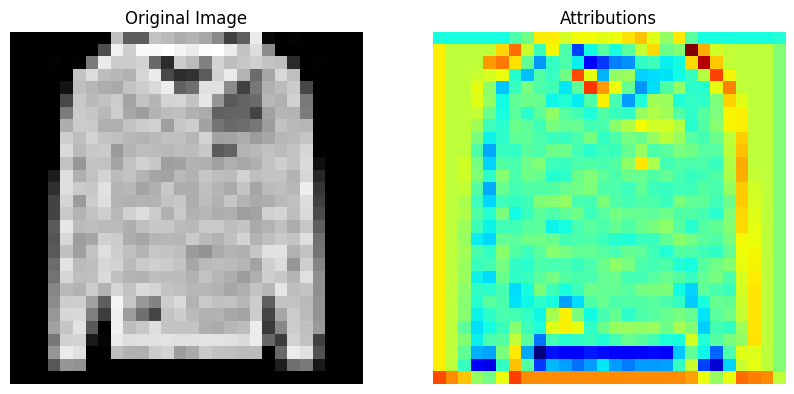

In [ ]:
# Plot the original image and its attributions
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image_np, cmap="gray")
axs[0].set_title("Original Image")
axs[0].axis("off")
axs[1].imshow(attributions_np, cmap="jet")
axs[1].set_title("Attributions")
axs[1].axis("off")

plt.show()

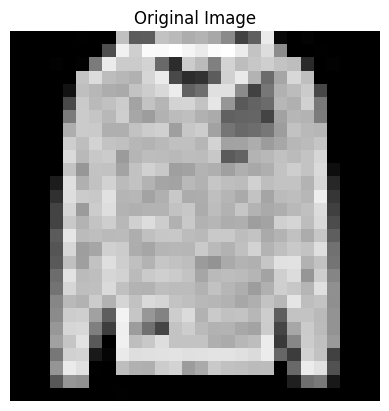

Predicted Class: 4


In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.transforms import functional as TF

# Remove the extra dimension from the image tensor
image = image.squeeze()

# Convert the image tensor to a NumPy array
image_np = image.detach().cpu().numpy()

# Reshape the image array to (28, 28)
image_np = image_np.reshape(28, 28)

# Display the original image
plt.imshow(image_np, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.show()

# Reshape the image tensor for resizing
image_reshaped = image.view(1, 1, 28, 28)

# Resize the image to match the expected input size of the model
resized_image = F.interpolate(image_reshaped, size=(28, 28))

# Get the predicted class label
predicted_label = model(resized_image.to(device)).argmax().item()

# Display the predicted class label
print('Predicted Class:', predicted_label)


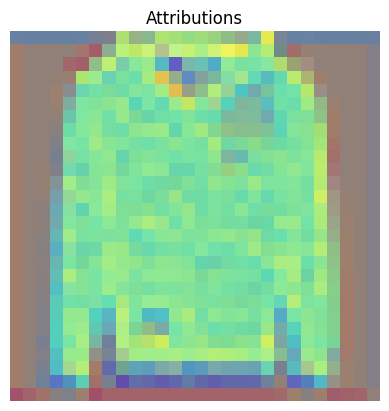

In [ ]:
import matplotlib.pyplot as plt

# Display the attributions
plt.imshow(attributions_np, cmap='jet', alpha=0.5)
plt.imshow(image_np, alpha=0.5)
plt.axis('off')
plt.title('Attributions')
plt.show()


In [ ]:
import numpy as np

def analyze_xai_results(attributions_np):
    # Calculate the average attribution score for each pixel
    avg_attributions = np.mean(attributions_np, axis=0)

    # Identify the pixels with the highest average attribution scores
    top_pixels = np.argsort(avg_attributions)[::-1][:10]

    # Print the top pixels with their corresponding average attribution scores
    print("Top Pixels:")
    for pixel in top_pixels:
        print(f"Pixel {pixel}: Average Attribution = {avg_attributions[pixel]}")

    # Visualize the attributions
    plt.imshow(attributions_np, cmap='jet')
    plt.title('Attributions')
    plt.colorbar()
    plt.show()

    # Additional analysis and visualization code can be added here

    # Return any relevant insights or analysis results
    return avg_attributions, top_pixels


In [ ]:
# Choose a random image from the test set
random_index = torch.randint(0, len(test_dataset), (1,))
image, label = test_dataset[random_index]
image = image.unsqueeze(0).to(device)


# Create a LayerGradCam instance
layer_name = model.conv2  # Replace 'model.conv1' with the actual layer object from your model
layer_grad_cam = LayerGradCam(model, layer_name)

# Compute the attribution using Grad-CAM
attributions = layer_grad_cam.attribute(image, target=torch.tensor(label).unsqueeze(0).to(device))

# Convert the tensor image and attributions to numpy arrays
image_np = image.squeeze().cpu().numpy()
attributions_np = attributions.squeeze().detach().cpu().numpy()






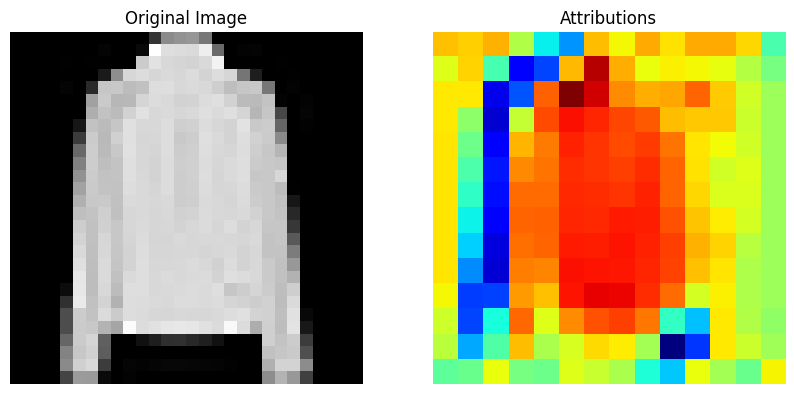

In [ ]:
# Plot the original image and its attributions
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image_np, cmap="gray")
axs[0].set_title("Original Image")
axs[0].axis("off")
axs[1].imshow(attributions_np, cmap="jet")
axs[1].set_title("Attributions")
axs[1].axis("off")

plt.show()



Top Pixels:
Pixel 6: Average Attribution = 0.016309505328536034
Pixel 7: Average Attribution = 0.010680126026272774
Pixel 5: Average Attribution = 0.009618344716727734
Pixel 8: Average Attribution = 0.006356130354106426
Pixel 4: Average Attribution = -0.007733715232461691
Pixel 9: Average Attribution = -0.008755113929510117
Pixel 11: Average Attribution = -0.00918832141906023
Pixel 0: Average Attribution = -0.011482800357043743
Pixel 3: Average Attribution = -0.012124666012823582
Pixel 10: Average Attribution = -0.01322915405035019


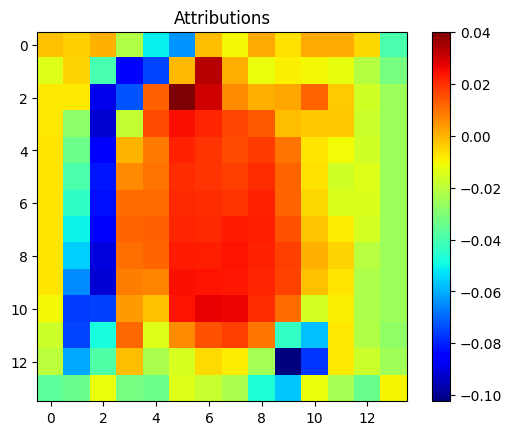

(array([-0.0114828 , -0.04132866, -0.06511433, -0.01212467, -0.00773372,
         0.00961834,  0.01630951,  0.01068013,  0.00635613, -0.00875511,
        -0.01322915, -0.00918832, -0.01869019, -0.02584582], dtype=float32),
 array([ 6,  7,  5,  8,  4,  9, 11,  0,  3, 10]))

In [ ]:
# Analyze the xAI results and gain insights
analyze_xai_results(attributions_np)

In [ ]:
# Define the threshold for identifying problematic images
threshold = 0.5

# Define the is_problematic function with your own logic
def is_problematic(image, attribution):
    # Calculate the average attribution score for the image
    avg_attribution = np.mean(attribution)

    # Return True if the average attribution score is below the threshold
    return avg_attribution < threshold





In [ ]:
# Modify the dataset based on the xAI analysis (Example: removing problematic images)
modified_train_images = []  # Modify the train_images based on the analysis
modified_train_labels = []  # Modify the train_labels accordingly

for i in range(len(train_images)):
    # Add your modification logic based on the xAI analysis
    # Example: Check if the attribution array has valid dimensions
    if i >= len(attributions_np):
        print(f"Error: Attribution for image {i} is missing.")
        continue

    # Example: Remove images identified as problematic
    if not is_problematic(train_images[i], attributions_np[i]):
        modified_train_images.append(train_images[i])
        modified_train_labels.append(train_labels[i])


Streaming output truncated to the last 5000 lines.
Error: Attribution for image 55000 is missing.
Error: Attribution for image 55001 is missing.
Error: Attribution for image 55002 is missing.
Error: Attribution for image 55003 is missing.
Error: Attribution for image 55004 is missing.
Error: Attribution for image 55005 is missing.
Error: Attribution for image 55006 is missing.
Error: Attribution for image 55007 is missing.
Error: Attribution for image 55008 is missing.
Error: Attribution for image 55009 is missing.
Error: Attribution for image 55010 is missing.
Error: Attribution for image 55011 is missing.
Error: Attribution for image 55012 is missing.
Error: Attribution for image 55013 is missing.
Error: Attribution for image 55014 is missing.
Error: Attribution for image 55015 is missing.
Error: Attribution for image 55016 is missing.
Error: Attribution for image 55017 is missing.
Error: Attribution for image 55018 is missing.
Error: Attribution for image 55019 is missing.
Error: At

In [ ]:
# Modify the dataset based on the xAI analysis (Example: removing problematic images)
modified_train_images = []  # Modify the train_images based on the analysis
modified_train_labels = []  # Modify the train_labels accordingly

for i in range(len(train_images)):
    # Add your modification logic based on the xAI analysis
    # Example: Remove images identified as problematic
    if not is_problematic(train_images[i], attributions_np[i]):
        modified_train_images.append(train_images[i])
        modified_train_labels.append(train_labels[i])

IndexError: ignored

In [ ]:
#NEW CODE --------------------------------------------------------------

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the dataset on Google Drive
dataset_path = '/content/drive/MyDrive/archive/'

In [ ]:
# Import necessary libraries
import numpy as np
import os
import struct


In [ ]:
# Define a function to load Fashion-MNIST dataset
def load_fashion_mnist(path):
    train_images_path = os.path.join(path, 'train-images-idx3-ubyte')
    train_labels_path = os.path.join(path, 'train-labels-idx1-ubyte')
    test_images_path = os.path.join(path, 't10k-images-idx3-ubyte')
    test_labels_path = os.path.join(path, 't10k-labels-idx1-ubyte')

    # Load training images
    with open(train_images_path, 'rb') as f:
        _, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        train_images = np.fromfile(f, dtype=np.uint8).reshape(num_images, num_rows, num_cols)

    # Load training labels
    with open(train_labels_path, 'rb') as f:
        _, num_labels = struct.unpack('>II', f.read(8))
        train_labels = np.fromfile(f, dtype=np.uint8)

    # Load test images
    with open(test_images_path, 'rb') as f:
        _, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        test_images = np.fromfile(f, dtype=np.uint8).reshape(num_images, num_rows, num_cols)

    # Load test labels
    with open(test_labels_path, 'rb') as f:
        _, num_labels = struct.unpack('>II', f.read(8))
        test_labels = np.fromfile(f, dtype=np.uint8)

    return train_images, train_labels, test_images, test_labels

In [ ]:
# Load the Fashion-MNIST dataset
train_images, train_labels, test_images, test_labels = load_fashion_mnist(dataset_path)

In [ ]:
# Print dataset information
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [ ]:
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [ ]:
# Create custom Dataset class
class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Create train and test datasets
train_dataset = FashionMNISTDataset(train_images, train_labels, transform)
test_dataset = FashionMNISTDataset(test_images, test_labels, transform)

In [ ]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = FashionMNISTModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

In [ ]:
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

print("Training finished.")

Epoch [1/10], Loss: 0.22578200697898865
Epoch [2/10], Loss: 0.2133622169494629
Epoch [3/10], Loss: 0.1847487986087799
Epoch [4/10], Loss: 0.14313867688179016
Epoch [5/10], Loss: 0.039858799427747726
Epoch [6/10], Loss: 0.0626019611954689
Epoch [7/10], Loss: 0.05234896391630173
Epoch [8/10], Loss: 0.14986707270145416
Epoch [9/10], Loss: 0.15818381309509277
Epoch [10/10], Loss: 0.11049781739711761
Training finished.


In [ ]:
# Calculate accuracy
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print('Accuracy: {:.2f}%'.format(accuracy))

Accuracy: 91.52%


In [ ]:
!pip install captum

In [ ]:
import torch
from captum.attr import LayerGradCam
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.transforms import functional as TF

In [ ]:
# Choose a random image from the test set
random_index = torch.randint(0, len(test_dataset), (1,))
image, label = test_dataset[random_index]
image = image.unsqueeze(0).to(device)


In [ ]:
# Create a LayerGradCam instance
layer_name = model.conv1
layer_grad_cam = LayerGradCam(model, layer_name)

# Compute the attribution using Grad-CAM
attributions = layer_grad_cam.attribute(image, target=torch.tensor(label).unsqueeze(0).to(device))


In [ ]:
# Convert the tensor image and attributions to numpy arrays
image_np = image.squeeze().cpu().numpy()
attributions_np = attributions.squeeze().detach().cpu().numpy()


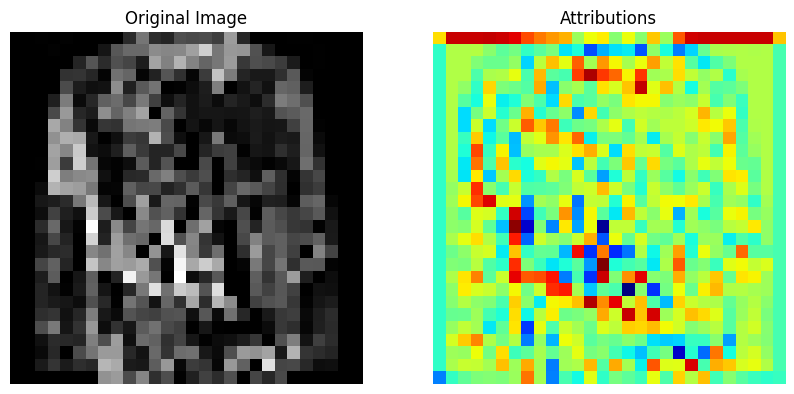

In [ ]:
# Plot the original image and its attributions
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image_np, cmap="gray")
axs[0].set_title("Original Image")
axs[0].axis("off")
axs[1].imshow(attributions_np, cmap="jet")
axs[1].set_title("Attributions")
axs[1].axis("off")

plt.show()

In [ ]:
# Calculate accuracy
correct = 0
total = 0
predicted_labels = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.tolist())  # Collect predicted labels

accuracy = 100 * correct / total
print('Accuracy: {:.2f}%'.format(accuracy))



Accuracy: 92.03%


In [ ]:
# Calculate accuracy using Grad-CAM
correct_gradcam = 0
total = len(test_dataset)

for i in range(total):
    image, label = test_dataset[i]
    image = image.unsqueeze(0).to(device)

    # Create a LayerGradCam instance
    layer_name = model.fc2 # Replace 'model.conv1' with the actual layer object from your model
    layer_grad_cam = LayerGradCam(model, layer_name)

    # Compute the attribution using Grad-CAM
    attributions = layer_grad_cam.attribute(image, target=torch.tensor(label).unsqueeze(0).to(device))

    # Get the predicted class label
    predicted_label = torch.argmax(attributions).item()

    if predicted_label == label:
        correct_gradcam += 1

accuracy_gradcam = 100 * correct_gradcam / total
print('Accuracy with Grad-CAM: {:.2f}%'.format(accuracy_gradcam))


Accuracy with Grad-CAM: 10.00%


In [ ]:
# Calculate accuracy using xAI (Grad-CAM)
correct_xai = 0
total = len(test_dataset)

for i in range(total):
    image, label = test_dataset[i]
    image = image.unsqueeze(0).to(device)

    # Create a LayerGradCam instance
    layer_name = model.conv1  # Replace 'model.conv1' with the actual layer object from your model
    layer_grad_cam = LayerGradCam(model, layer_name)

    # Compute the attribution using Grad-CAM
    attributions = layer_grad_cam.attribute(image, target=torch.tensor(label).unsqueeze(0).to(device))

    # Convert the tensor attributions to numpy array
    attributions_np = attributions.squeeze().detach().cpu().numpy()

    # Rescale the attributions to the range [0, 1]
    attributions_np = (attributions_np - attributions_np.min()) / (attributions_np.max() - attributions_np.min())

    # Apply a threshold to obtain the binary mask
    threshold = 0.5
    mask = (attributions_np > threshold).astype(np.float32)

    # Get the masked image by applying the binary mask
    masked_image = image.squeeze().detach().cpu().numpy() * mask

    # Reshape and normalize the masked image
    masked_image = masked_image.reshape(28, 28)
    masked_image = (masked_image - masked_image.min()) / (masked_image.max() - masked_image.min())

    # Reshape and normalize the original image
    image_np = image.squeeze().detach().cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())



    # Get the predicted class label
    predicted_label = model(image).argmax().item()

    if predicted_label == label:
        correct_xai += 1

accuracy_xai = 100 * correct_xai / total
print('Accuracy with xAI: {:.2f}%'.format(accuracy_xai))


Accuracy with xAI: 92.03%


In [ ]:
import torch
from captum.attr import IntegratedGradients

# Calculate accuracy using Integrated Gradients
correct_xai = 0
total = len(test_dataset)

for i in range(total):
    image, label = test_dataset[i]
    image = image.unsqueeze(0).to(device)

    # Create an IntegratedGradients instance
    integrated_gradients = IntegratedGradients(model)

    # Compute the attribution using Integrated Gradients
    attributions = integrated_gradients.attribute(image, target=torch.tensor(label).unsqueeze(0).to(device))

    # Convert the tensor attributions to numpy array
    attributions_np = attributions.squeeze().detach().cpu().numpy()

    # Rescale the attributions to the range [0, 1]
    attributions_np = (attributions_np - attributions_np.min()) / (attributions_np.max() - attributions_np.min())

    # Apply a threshold to obtain the binary mask
    threshold = 0.5
    mask = (attributions_np > threshold).astype(np.float32)

    # Get the masked image by applying the binary mask
    masked_image = image.squeeze().detach().cpu().numpy() * mask

    # Reshape and normalize the masked image
    masked_image = masked_image.reshape(28, 28)
    masked_image = (masked_image - masked_image.min()) / (masked_image.max() - masked_image.min())

    # Reshape and normalize the original image
    image_np = image.squeeze().detach().cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())


    # Get the predicted class label
    predicted_label = model(image).argmax().item()

    if predicted_label == label:
        correct_xai += 1

accuracy_xai = 100 * correct_xai / total
print('Accuracy with xAI (Integrated Gradients): {:.2f}%'.format(accuracy_xai))


Accuracy with xAI (Integrated Gradients): 91.70%


In [ ]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model instance
model = FashionMNISTModel().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

print("Training finished.")

# Save the model
torch.save(model.state_dict(), "/content/drive/MyDrive/model.pth")

# Set the model to evaluation mode
model.eval()

Epoch [1/10], Loss: 0.36944758892059326
Epoch [2/10], Loss: 0.3012235760688782
Epoch [3/10], Loss: 0.2721201777458191
Epoch [4/10], Loss: 0.2137092649936676
Epoch [5/10], Loss: 0.039497874677181244
Epoch [6/10], Loss: 0.17258617281913757
Epoch [7/10], Loss: 0.14396384358406067
Epoch [8/10], Loss: 0.017538584768772125
Epoch [9/10], Loss: 0.10711315274238586
Epoch [10/10], Loss: 0.06548839062452316
Training finished.


FashionMNISTModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from captum.attr import GradientShap

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the custom Dataset class
class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Create the test dataset
test_dataset = FashionMNISTDataset(test_images, test_labels, transform)

# Create the data loader
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained model
model = FashionMNISTModel().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/model.pth"))
model.eval()

# Calculate accuracy using GradientShap
correct_xai = 0
total = len(test_dataset)

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    # Create the GradientShap instance
    gradient_shap = GradientShap(model)

    # Define baselines
    baselines = torch.zeros_like(images)

    # Compute the attributions using GradientShap
    target_idx = torch.argmax(model(images), dim=1)
    attributions = gradient_shap.attribute(images, baselines=baselines, n_samples=50, target=target_idx)

    # Get the predicted class labels
    predicted_labels = torch.argmax(model(images), dim=1)

    # Count the correct predictions
    correct_xai += torch.sum(predicted_labels == labels).item()

accuracy_xai = 100 * correct_xai / total
print('Accuracy with xAI (GradientShap): {:.2f}%'.format(accuracy_xai))


Accuracy with xAI (GradientShap): 91.70%


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the dataset on Google Drive
dataset_path = '/content/drive/MyDrive/archive/'

# Import necessary libraries
import numpy as np
import os
import struct

# Define a function to load Fashion-MNIST dataset
def load_fashion_mnist(path):
    train_images_path = os.path.join(path, 'train-images-idx3-ubyte')
    train_labels_path = os.path.join(path, 'train-labels-idx1-ubyte')
    test_images_path = os.path.join(path, 't10k-images-idx3-ubyte')
    test_labels_path = os.path.join(path, 't10k-labels-idx1-ubyte')

    # Load training images
    with open(train_images_path, 'rb') as f:
        _, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        train_images = np.fromfile(f, dtype=np.uint8).reshape(num_images, num_rows, num_cols)

    # Load training labels
    with open(train_labels_path, 'rb') as f:
        _, num_labels = struct.unpack('>II', f.read(8))
        train_labels = np.fromfile(f, dtype=np.uint8)

    # Load test images
    with open(test_images_path, 'rb') as f:
        _, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        test_images = np.fromfile(f, dtype=np.uint8).reshape(num_images, num_rows, num_cols)

    # Load test labels
    with open(test_labels_path, 'rb') as f:
        _, num_labels = struct.unpack('>II', f.read(8))
        test_labels = np.fromfile(f, dtype=np.uint8)

    return train_images, train_labels, test_images, test_labels

# Load the Fashion-MNIST dataset
train_images, train_labels, test_images, test_labels = load_fashion_mnist(dataset_path)

# Print dataset information
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Create custom Dataset class
class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Create train and test datasets
train_size = int(0.05 * len(train_images))
test_size = int(0.05 * len(test_images))

train_dataset = FashionMNISTDataset(train_images[:train_size], train_labels[:train_size], transform)
test_dataset = FashionMNISTDataset(test_images[:test_size], test_labels[:test_size], transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FashionMNISTModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

print("Training finished.")

# Calculate accuracy
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print('Accuracy: {:.2f}%'.format(accuracy))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)
Epoch [1/10], Loss: 0.5500996708869934
Epoch [2/10], Loss: 0.7222456932067871
Epoch [3/10], Loss: 0.5037561655044556
Epoch [4/10], Loss: 0.301472008228302
Epoch [5/10], Loss: 0.24762915074825287
Epoch [6/10], Loss: 0.2719910442829132
Epoch [7/10], Loss: 0.3147140145301819
Epoch [8/10], Loss: 0.3792015612125397
Epoch [9/10], Loss: 0.2841692864894867
Epoch [10/10], Loss: 0.17748498916625977
Training finished.
Accuracy: 87.20%


In [ ]:
# Save the model
torch.save(model.state_dict(), "/content/drive/MyDrive/model_2.pth")

# Set the model to evaluation mode
model.eval()

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from captum.attr import GradientShap

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the custom Dataset class
class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Create the test dataset
test_dataset = FashionMNISTDataset(test_images, test_labels, transform)

# Create the data loader
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained model
model = FashionMNISTModel().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/model_2.pth"))
model.eval()

# Calculate accuracy using GradientShap
correct_xai = 0
total = len(test_dataset)

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    # Create the GradientShap instance
    gradient_shap = GradientShap(model)

    # Define baselines
    baselines = torch.zeros_like(images)

    # Compute the attributions using GradientShap
    target_idx = torch.argmax(model(images), dim=1)
    attributions = gradient_shap.attribute(images, baselines=baselines, n_samples=50, target=target_idx)

    # Get the predicted class labels
    predicted_labels = torch.argmax(model(images), dim=1)

    # Count the correct predictions
    correct_xai += torch.sum(predicted_labels == labels).item()

accuracy_xai = 100 * correct_xai / total
print('Accuracy with xAI (GradientShap): {:.2f}%'.format(accuracy_xai))


FileNotFoundError: ignored